In [1]:
#from google.colab import files
#files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"quadribello","key":"107d36b09c8ce58052c74ffd53d29fd9"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d tmdb/tmdb-movie-metadata

 56% 5.00M/8.89M [00:02<00:01, 2.31MB/s]
100% 8.89M/8.89M [00:02<00:00, 4.02MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('tmdb-movie-metadata.zip','r')
zip_ref.extractall('files')
zip_ref.close()

In [5]:
import json
import pandas as pd 
import numpy as np 
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud



## Loading the data
The TMDb data includes several nested json fields, so loading the data requires an extra step beyond reading the csv files.

In [6]:
def load_tmdb_movies(path):
    df = pd.read_csv(path)
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df


def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

In [7]:
movies = load_tmdb_movies('/content/files/tmdb_5000_movies.csv')
credits = load_tmdb_credits('/content/files/tmdb_5000_credits.csv')

In [8]:
print(movies.shape)
print(credits.shape)

(4803, 20)
(4803, 4)


In [9]:
movies.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,19995,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-12-10,2787965087,162.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",http://disney.go.com/disneypictures/pirates/,285,"[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2007-05-19,961000000,169.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


In [10]:
credits.head(2)

,movie_id,title,cast,crew
0,19995,Avatar,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de..."
1,285,Pirates of the Caribbean: At World's End,"[{'cast_id': 4, 'character': 'Captain Jack Spa...","[{'credit_id': '52fe4232c3a36847f800b579', 'de..."


##Working with the json fields

As we've seen, almost all of the data in the credits file is actually nested json. Since we've loaded the json fields properly, theose fields can be accessed just like any other list or dictionary.

The cast field contains the following keys:

In [11]:
print(sorted(credits.cast.iloc[0][0].keys()))

['cast_id', 'character', 'credit_id', 'gender', 'id', 'name', 'order']


The crew field contains the following keys:

In [12]:
print(sorted(credits.crew.iloc[0][0].keys()))

['credit_id', 'department', 'gender', 'id', 'job', 'name']


The keywords field contains the following keys

In [13]:
print(sorted(movies.keywords.iloc[0][0].keys()))

['id', 'name']


The genres field contains the following keys

In [14]:
print(sorted(movies.genres.iloc[0][0].keys()))

['id', 'name']


The  production_companies contains the following keys

In [15]:
print(sorted(movies.production_companies.iloc[0][0].keys()))

['id', 'name']


The production_countries contains the following keys

In [16]:
print(sorted(movies.production_countries.iloc[0][0].keys()))

['iso_3166_1', 'name']


The spoken_languages contains the following keys

In [17]:
print(sorted(movies.spoken_languages.iloc[0][0].keys()))

['iso_639_1', 'name']


the cast and crew lists are already sorted by the order of appeareance in the film's credits. For example, we can get the names of the first five actors in Avatar with

In [18]:
[actor['name'] for actor in credits['cast'].iloc[0][:5]]

['Sam Worthington',
 'Zoe Saldana',
 'Sigourney Weaver',
 'Stephen Lang',
 'Michelle Rodriguez']

In [19]:
def safe_access(container, index_values):
    # return a missing value rather than an error upon indexing/key failure
    result = container
    try:
        for idx in index_values:
            result = result[idx]
        return result
    except IndexError or KeyError:
        return pd.np.nan

In [20]:
credits['gender_of_lead'] = credits.cast.apply(lambda x: safe_access(x, [0, 'gender']))
credits['lead'] = credits.cast.apply(lambda x: safe_access(x, [0, 'name']))
credits.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  if __name__ == '__main__':


,movie_id,title,cast,crew,gender_of_lead,lead
0,19995,Avatar,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de...",2.0,Sam Worthington
1,285,Pirates of the Caribbean: At World's End,"[{'cast_id': 4, 'character': 'Captain Jack Spa...","[{'credit_id': '52fe4232c3a36847f800b579', 'de...",2.0,Johnny Depp
2,206647,Spectre,"[{'cast_id': 1, 'character': 'James Bond', 'cr...","[{'credit_id': '54805967c3a36829b5002c41', 'de...",2.0,Daniel Craig
3,49026,The Dark Knight Rises,"[{'cast_id': 2, 'character': 'Bruce Wayne / Ba...","[{'credit_id': '52fe4781c3a36847f81398c3', 'de...",2.0,Christian Bale
4,49529,John Carter,"[{'cast_id': 5, 'character': 'John Carter', 'c...","[{'credit_id': '52fe479ac3a36847f813eaa3', 'de...",2.0,Taylor Kitsch


I will merge the two dataset 

In [21]:
credits.columns = ['id','tittle','cast','crew', 'gender_of_lead','lead']
df= movies.merge(credits,on='id')

Now we can create a new column for the gender. It's trinary data ({other: 0, female: 1, male: 2}), but that's the best we can do with the data on hand

In [22]:
credits.gender_of_lead.value_counts()

2.0    3329
1.0    1167
0.0     264
Name: gender_of_lead, dtype: int64

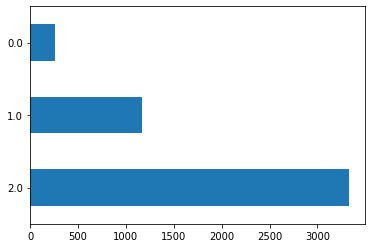

In [23]:
credits['gender_of_lead'].value_counts().plot(kind='barh')

gender disparity,  Men are the lead in most of the movies



In [24]:
credits.rename(columns={'movie_id': 'id', 'crew': 'Director'}, inplace=True)

In [25]:
df = pd.merge(movies, credits,on="id")

In [26]:
df.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,tittle,cast,Director,gender_of_lead,lead
0,237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,19995,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-12-10,2787965087,162.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de...",2.0,Sam Worthington
1,300000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",http://disney.go.com/disneypictures/pirates/,285,"[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2007-05-19,961000000,169.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{'cast_id': 4, 'character': 'Captain Jack Spa...","[{'credit_id': '52fe4232c3a36847f800b579', 'de...",2.0,Johnny Depp


In [27]:
# info on variable types and filling factor
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'null values (%)'}))
tab_info

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,tittle,cast,Director,gender_of_lead,lead
column type,int64,object,object,int64,object,object,object,object,float64,object,object,object,int64,float64,object,object,object,object,float64,int64,object,object,object,float64,object
null values,0,0,3091,0,0,0,0,3,0,0,0,1,0,2,0,0,844,0,0,0,0,0,0,43,43
null values (%),0,0,64.3556,0,0,0,0,0.062461,0,0,0,0.0208203,0,0.0416406,0,0,17.5724,0,0,0,0,0,0,0.895274,0.895274


In [28]:
df.shape

(4803, 25)

I will drop homepage column because of the high percentage of null values, I will also drop tittle, tiltle column because it is the same with original_title column

In [29]:
df.drop(['homepage','tittle','title'],axis=1,inplace=True)

In [30]:
df.shape

(4803, 22)

In [89]:
df.sample(5)

,budget,genres,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,vote_average,vote_count,cast,Director,gender_of_lead,lead,Year,month,weekday,profit,profit_rate
3700,4500000,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",9303,"[{'id': 378, 'name': 'prison'}, {'id': 5424, '...",en,Bound,"Corky, a tough female ex con and her lover Vio...",15.359952,"[{'name': 'Dino De Laurentiis Company', 'id': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",1996-09-13,7011317,108.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"In their world, you can't buy freedom, but you...",6.9,198,"[{'cast_id': 1, 'character': 'Violet', 'credit...","[{'credit_id': '54f052b8c3a3686d580079ef', 'de...",1.0,Jennifer Tilly,1996,9,4,2511317,0.558070
3608,5000000,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",29996,"[{'id': 536, 'name': 'israel'}, {'id': 1160, '...",en,Solomon and Sheba,"Under the rule of King David, Israel is united...",0.835617,"[{'name': 'Edward Small Productions', 'id': 13...","[{'iso_3166_1': 'US', 'name': 'United States o...",1959-12-25,12200000,139.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Only once in 3000 years...anything like...,5.4,8,"[{'cast_id': 4, 'character': 'Solomon', 'credi...","[{'credit_id': '52fe4609c3a368484e07d509', 'de...",2.0,Yul Brynner,1959,12,4,7200000,1.440000
1019,55000000,"[{'id': 37, 'name': 'Western'}]",5176,"[{'id': 1582, 'name': 'saloon'}, {'id': 1701, ...",en,3:10 to Yuma,"In Arizona in the late 1800's, infamous outlaw...",48.801089,"[{'name': 'Tree Line Films', 'id': 84}, {'name...","[{'iso_3166_1': 'US', 'name': 'United States o...",2007-09-06,70016220,122.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Time waits for one man.,6.9,1188,"[{'cast_id': 1, 'character': 'Ben Wade', 'cred...","[{'credit_id': '52fe43fac3a36847f807b735', 'de...",2.0,Russell Crowe,2007,9,3,15016220,0.273022
3586,5000000,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",256274,"[{'id': 90, 'name': 'paris'}, {'id': 1454, 'na...",en,"As Above, So Below",When a team of explorers ventures into the cat...,26.510558,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'iso_3166_1': 'US', 'name': 'United States o...",2014-08-14,40100000,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The only way out is down.,6.1,766,"[{'cast_id': 3, 'character': 'Scarlett', 'cred...","[{'credit_id': '54ab11d9c3a36822b7002686', 'de...",1.0,Perdita Weeks,2014,8,3,35100000,7.020000
2037,22000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10751, '...",82650,"[{'id': 12392, 'name': 'best friend'}, {'id': ...",en,Diary of a Wimpy Kid: Dog Days,School is out and Greg is ready for the days o...,13.410919,"[{'name': 'Fox 2000 Pictures', 'id': 711}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-08-02,77112176,94.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,School's Out for the summer,6.0,223,"[{'cast_id': 15, 'character': 'Greg Heffley', ...","[{'credit_id': '52fe48649251416c9108ab97', 'de...",2.0,Zachary Gordon,2012,8,3,55112176,2.505099


drop revenues that are smaller and equal to zero

In [32]:
df=df[df.revenue>0]

In [33]:
df.shape

(3376, 22)

getting date information

In [34]:
df.release_date = pd.to_datetime(df.release_date,  errors='coerce')
df['Year'] = df.release_date.dt.year
df['month'] = df.release_date.dt.month
df['weekday'] = df.release_date.dt.weekday

DATA BUDGET, REVENUE AND PROFIT IN YEARS

In [35]:
df['profit'] = df['revenue'] - df['budget']
df['profit_rate'] = df['profit'] / df['budget']

In [36]:
revenues = df.groupby('Year')['revenue'].sum()
budgets = df.groupby('Year')['budget'].sum()
profits = df.groupby('Year')['profit'].sum()

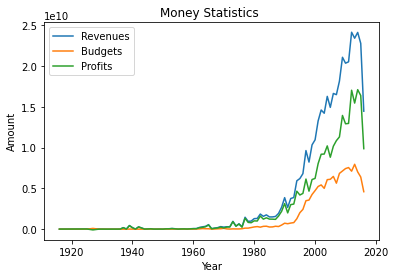

In [37]:
x1 = df['Year']
y1 = revenues
# plotting the revenue points 
plt.plot(revenues, label = "Revenues")
# line 2 points
x2 = df['Year']
y2 = budgets
# plotting the budgets points 
plt.plot(budgets, label = "Budgets")
x3 = df['Year']
y3 = profits
# plotting the profits points 
plt.plot(profits, label = "Profits")
plt.xlabel('Year')
# Set the y axis label of the current axis.
plt.ylabel('Amount')
# Set a title of the current axes.
plt.title('Money Statistics ')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

#The revenue peak is in 2012, let check out the movies

In [38]:
def pipe_flatten_names(keywords):
    return '|'.join([x['name'] for x in keywords])

In [39]:
df0 = df.copy()

In [40]:
df0['genres'] = df0['genres'].apply(pipe_flatten_names)

In [41]:
top_10 = df0[df0['Year'] == 2012]
top_10.sort_values(by="revenue", ascending=False)[['original_title', 'budget', 'revenue', 'profit', 'genres']].head(10)

,original_title,budget,revenue,profit,genres
16,The Avengers,220000000,1519557910,1299557910,Science Fiction|Action|Adventure
29,Skyfall,200000000,1108561013,908561013,Action|Adventure|Thriller
3,The Dark Knight Rises,250000000,1084939099,834939099,Action|Crime|Drama|Thriller
98,The Hobbit: An Unexpected Journey,250000000,1021103568,771103568,Adventure|Fantasy|Action
325,Ice Age: Continental Drift,95000000,877244782,782244782,Animation|Comedy|Adventure|Family
172,The Twilight Saga: Breaking Dawn - Part 2,120000000,829000000,709000000,Adventure|Fantasy|Drama|Romance
20,The Amazing Spider-Man,215000000,752215857,537215857,Action|Adventure|Fantasy
146,Madagascar 3: Europe's Most Wanted,145000000,746921274,601921274,Animation|Family
426,The Hunger Games,75000000,691210692,616210692,Science Fiction|Adventure|Fantasy
18,Men in Black 3,225000000,624026776,399026776,Action|Comedy|Science Fiction


##The profit peak is in 2012 & 2014, let check out the top proftitable movies in 2014

In [42]:
top_10 = df0[df0['Year'] == 2014]
top_10.sort_values(by="profit", ascending=False)[['original_title', 'budget', 'revenue', 'profit', 'genres']].head(10)

,original_title,budget,revenue,profit,genres
36,Transformers: Age of Extinction,210000000,1091405097,881405097,Science Fiction|Action|Adventure
19,The Hobbit: The Battle of the Five Armies,250000000,956019788,706019788,Action|Adventure|Fantasy
200,The Hunger Games: Mockingjay - Part 1,125000000,752100229,627100229,Science Fiction|Adventure|Thriller
94,Guardians of the Galaxy,170000000,773328629,603328629,Action|Science Fiction|Adventure
81,Maleficent,180000000,758539785,578539785,Fantasy|Adventure|Action|Family|Romance
85,Captain America: The Winter Soldier,170000000,714766572,544766572,Action|Adventure|Science Fiction
82,Dawn of the Planet of the Apes,170000000,710644566,540644566,Science Fiction|Action|Drama|Thriller
95,Interstellar,165000000,675120017,510120017,Adventure|Drama|Science Fiction
38,The Amazing Spider-Man 2,200000000,705717432,505717432,Action|Adventure|Fantasy
46,X-Men: Days of Future Past,250000000,747862775,497862775,Action|Adventure|Fantasy|Science Fiction


##The movies with most profit rate

In [43]:
sub_data = df0[(df0['budget'] != 0) & (df0['revenue'] != 0) & (df0['budget'] > 10000000)]
sub_data.sort_values(by='profit_rate', ascending=False)[['original_title', 'budget', 'profit', 'genres', 'profit_rate', 'Year']].head(10)

,original_title,budget,profit,genres,profit_rate,Year
2967,E.T. the Extra-Terrestrial,10500000,782410554,Science Fiction|Adventure|Family|Fantasy,74.515291,1982
2912,Star Wars,11000000,764398007,Adventure|Action|Science Fiction,69.490728,1977
2668,Pretty Woman,14000000,449000000,Romance|Comedy,32.071429,1990
1990,The Empire Strikes Back,18000000,520400000,Adventure|Action|Science Fiction,28.911111,1980
2517,The King's Speech,15000000,399211549,Drama|History,26.614103,2010
2511,Home Alone,18000000,458684675,Comedy|Family,25.482482,1990
2838,The Fault in Our Stars,12000000,295166834,Romance|Drama,24.597236,2014
2730,Black Swan,13000000,314803731,Drama|Thriller,24.215672,2010
2666,Slumdog Millionaire,15000000,362910544,Drama|Romance,24.194036,2008
2096,The Conjuring,13000000,305000141,Horror|Thriller,23.461549,2013


we will need a metric score to rate our movie

We can use the average ratings of the movie as the score but using this won't be fair enough since a movie with 8.9 average rating and only 3 votes cannot be considered better than the movie with 7.8 as as average rating but 40 votes. So, I'll be using IMDB's weighted rating (wr) which is given as :

$$(\dfrac{v}{v+m}.R)+(\dfrac{m}{v+m}.C)$$

where,

* v is the number of votes for the movie;
* m is the minimum votes required to be listed in the chart;
* R is the average rating of the movie; And
* C is the mean vote across the whole report

We already have v(vote_count) and R (vote_average) and C can be calculated as

In [44]:
C= df['vote_average'].mean()
C

6.3087381516587575

So, the mean rating for all the movies is approx 6 on a scale of 10.The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 90th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 90% of the movies in the list.

In [45]:
m= df['vote_count'].quantile(0.9)
m

2429.0

In [46]:
q_movies = df.copy().loc[df['vote_count'] >= m]
q_movies.shape

(338, 27)

In [47]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [48]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

##Top 15 movies

In [49]:
#Sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)

#Print the top 15 movies
q_movies[['original_title', 'vote_count', 'vote_average', 'score']].head(10)

,original_title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,7.999476
662,Fight Club,9413,8.3,7.891558
65,The Dark Knight,12002,8.2,7.881666
3232,Pulp Fiction,8428,8.3,7.854502
96,Inception,13752,8.1,7.831106
3337,The Godfather,5893,8.4,7.789609
95,Interstellar,10867,8.1,7.772761
809,Forrest Gump,7927,8.2,7.756404
329,The Lord of the Rings: The Return of the King,8064,8.1,7.685345
1990,The Empire Strikes Back,5879,8.2,7.647054


I will visualize the most popular movies 

Text(0.5, 1.0, 'Popular Movies')

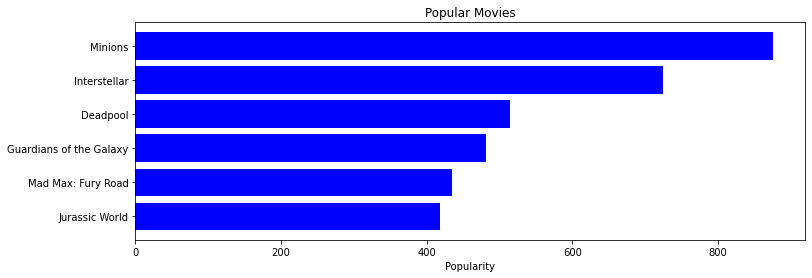

In [50]:
pop= df.sort_values('popularity', ascending=False)

plt.figure(figsize=(12,4))

plt.barh(pop['original_title'].head(6),pop['popularity'].head(6), align='center',color='blue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

##Keywords
The keywords describes the films. Indeed, a basic assumption is that films described by similar keywords should have similar contents

In [51]:
def pipe_flatten_names(keywords):
    return '|'.join([x['name'] for x in keywords])

In [52]:
keywords = df.copy()

In [53]:
keywords['keywords'] = keywords['keywords'].apply(pipe_flatten_names)

In [54]:
keywords['keywords']

0       culture clash|future|space war|space colony|so...
1       ocean|drug abuse|exotic island|east india trad...
2       spy|based on novel|secret agent|sequel|mi6|bri...
3       dc comics|crime fighter|terrorist|secret ident...
4       based on novel|mars|medallion|space travel|pri...
                              ...                        
4775                                           mumblecore
4788    gay|trailer park|pop culture|drug dealer|heroi...
4792    japan|prostitute|hotel|based on novel|hallucin...
4796    distrust|garage|identity crisis|time travel|ti...
4798    united states–mexico barrier|legs|arms|paper k...
Name: keywords, Length: 3376, dtype: object

In [55]:
set_keywords = set()
for liste_keywords in keywords['keywords'].str.split('|').values:
    if isinstance(liste_keywords, float): continue  # only happen if liste_keywords = NaN
    set_keywords = set_keywords.union(liste_keywords)

In [56]:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):        
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue        
        for s in [s for s in liste_keywords if s in liste]: 
            if pd.notnull(s): keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

In [57]:
keyword_occurences, dum = count_word(keywords,'keywords',set_keywords)
keyword_occurences[:5]

[['duringcreditsstinger', 278],
 ['woman director', 185],
 ['based on novel', 179],
 ['aftercreditsstinger', 152],
 ['murder', 143]]

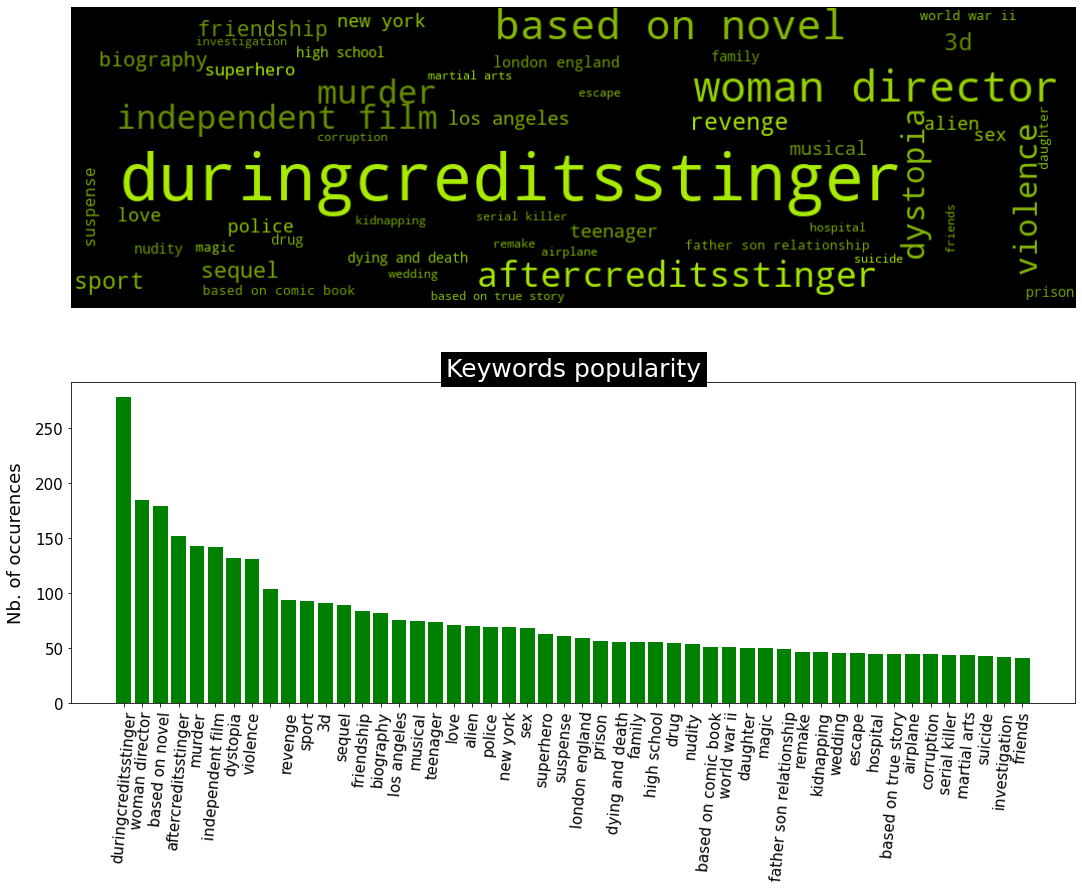

In [58]:
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
#_____________________________________________
# UPPER PANEL: WORDCLOUD
fig = plt.figure(1, figsize=(18,13))
ax1 = fig.add_subplot(2,1,1)
#_______________________________________________________
# I define the dictionary used to produce the wordcloud
words = dict()
trunc_occurences = keyword_occurences[0:50]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 55.0 # define the color of the words
#________________________________________________________
wordcloud = WordCloud(width=1000,height=300, background_color='black', max_words=1628,relative_scaling=1,color_func = random_color_func,normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
ax1.imshow(wordcloud, interpolation="bilinear")
ax1.axis('off')
#_____________________________________________
# LOWER PANEL: HISTOGRAMS
ax2 = fig.add_subplot(2,1,2)
y_axis = [i[1] for i in trunc_occurences]
x_axis = [k for k,i in enumerate(trunc_occurences)]
x_label = [i[0] for i in trunc_occurences]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax2.bar(x_axis, y_axis, align = 'center', color='g')
#_______________________
plt.title("Keywords popularity",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 25)
plt.show()

##Let's see now the correlation between all these variables among themselves

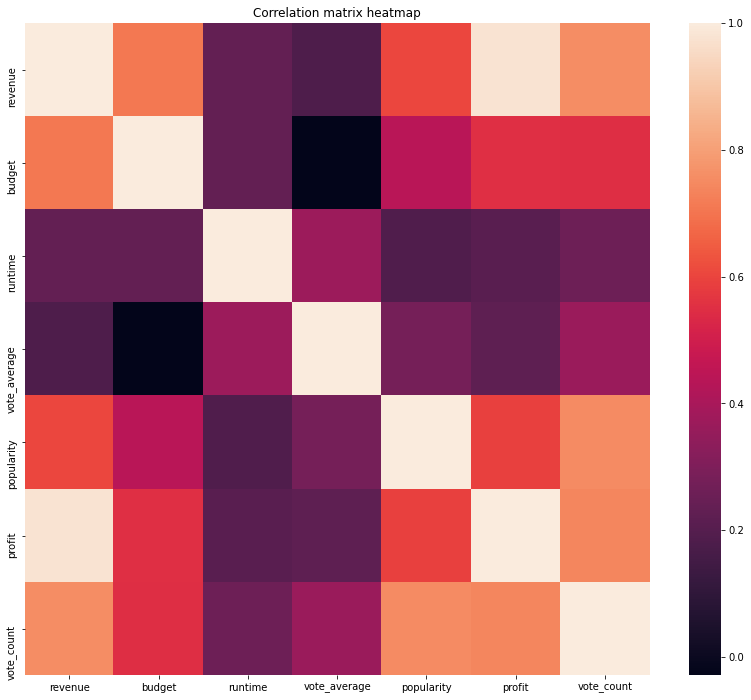

In [59]:
fig, ax = plt.subplots(figsize=(14,12));
new = df[['revenue','budget', 'runtime', 'vote_average', 'popularity','profit','vote_count']].copy()
new = new.corr()
sns.heatmap(new, ax=ax);
ax.set_title('Correlation matrix heatmap');

References :

* https://www.kaggle.com/sohier/film-recommendation-engine-converted-to-use-tmdb/comments

* https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system